# LRS fixedslit pipeline tutorial

### by Patrick Kavanagh (DIAS, Ireland) Feb 16th 2017

This notebook demonstrates the execution of the level 2A and 2B pipelines for LRS fixed slit data in Python using the jwst step classes.

Documentation on each pipeline step can be found here:

http://ssb.stsci.edu/doc/jwst_git/docs/

The pipeline steps are:

2A: dq_init, saturation, ipc, linearity, RSCD, lastframe, dark_current, refpix, persistence (no-op), jump, ramp_fitting

2B: assign_wcs, bkg_subtract (associations only), flat_field, srctype, photom, extract_1d

The file used in this notebook is a MIRISim simulation of a point source with a blackbody spectrum plus emission lines.

#### imports

In [1]:
import os, shutil, glob

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

from jwst import datamodels

#### Set input file, output directory for step outputs:

In [2]:
# set filename
input_file = 'det_image_1_MIRIMAGE_P750Lexp1.fits'

# extract the basename for use in output files
input_basename = os.path.splitext(input_file)[0]

# set the name of the output directory
output_dir = input_basename + '_step-output'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input file. 
Note that ground test data and MIRISim data will differ here. We can distinguish between the two using the 'ORIGIN' header keyword. Converted ground test data will always have 'STScI' as the origin.

Also note that there is currently a problem running MIRISim data step-wise through the pipeline. One must remove some of the extensions. This has been taken care of in the following cell. This issue has been reported to STScI and this notebook will be updated when it is resolved.

In [3]:
# print some info on input file
with fits.open(input_file) as hdulist:
        
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['EXP_TYPE']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print "ID\t\t\t Detector\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "%s\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (identifier,detector,im_filter,subArr,nInts,nGroups,readPatt,expTime)
        print "\n\n"
            
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['EXP_TYPE']
        im_filter = hdulist[0].header['FILTER']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        print "ID\t Type\t\t\t Filter\t subAr\t nInts\t nGrps\t rdPatt\t ExpTime (s)"
        print "--------------------------------------------------------------------------------------------------"
        print "MIRISim\t %s\t %s\t %s\t %d\t %d\t %s\t %0.1f" % (detector,im_filter,subArr, nInts,nGroups,readPatt,expTime)
        print "\n\n"

    # fits extension table
    hdulist.info()
    

ID	 Type			 Filter	 subAr	 nInts	 nGrps	 rdPatt	 ExpTime (s)
--------------------------------------------------------------------------------------------------
MIRISim	 MIR_LRS-FIXEDSLIT	 P750L	 FULL	 2	 15	 FAST	 83.3



Filename: det_image_1_MIRIMAGE_P750Lexp1.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     136   ()      
  1  SCI         ImageHDU        14   (1032, 1024, 15, 2)   float32   
  2  REFOUT      ImageHDU        14   (258, 1024, 15, 2)   float32   
  3  PIXELDQ     ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  4  PIXELDQ_DEF  BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   
  5  ASDF        ImageHDU         7   (163809533,)   uint8   


## DQ_INIT step ===================================================
This step creates the PIXELDQ, GROUPDQ and ERR extensions in the ramp file 
which are copied from the calibration file. See:

http://ssb.stsci.edu/doc/jwst_git/docs/dq_init/html/

We will define where we want the output written (removing any file from a previous run)

### DQ_INIT: load module and show options

In [4]:
# import the step
from jwst.dq_init import dq_init_step

# print the description and options
print dq_init_step.DQInitStep.__doc__
print dq_init_step.DQInitStep.spec

# set the output file name
dq_init_output_file = os.path.join(output_dir,'%s_dq_init.fits' % input_basename)

# delete output from a previous run
try: 
    os.remove(dq_init_output_file)
except OSError:
    pass



    DQInitStep:  Initialize the Data Quality extension from the
    mask reference file.  Also initialize the error extension

    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())

    output_dir = string(default=None) # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False) # Skip this step
    


### DQ_INIT: run step

In [5]:
# run the dq_init step
dq_init_step.DQInitStep.call(input_file, output_file=dq_init_output_file)

2017-02-16 10:59:28,778 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2017-02-16 10:59:31,201 - stpipe.DQInitStep - INFO - Prefetch for MASK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0019.fits'.
2017-02-16 10:59:31,279 - stpipe.DQInitStep - INFO - Step DQInitStep running with args ('det_image_1_MIRIMAGE_P750Lexp1.fits',).
2017-02-16 10:59:32,228 - stpipe.DQInitStep - INFO - Using MASK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_mask_0019.fits
2017-02-16 10:59:33,550 - stpipe.DQInitStep - INFO - Saving file /Users/patrickkavanagh/mirisim/testing/lrssim/slit/det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_dq_init.fits
2017-02-16 10:59:33,650 - stpipe.DQInitStep - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7/lib/python2.7/site-packages/astropy/utils/decorators.py:470: AstropyDeprecationWarning: "clobber" was deprecated in version 1.3 and will be removed in a 

### DQ_INIT:  output check

1. check the output fits file contains the calibration step information, look at the new extension table

2. check the output datamodel to show values in the new extensions, check that some pixels have been assigned new flags from the mask file

In [6]:
# check the output fits file information using astropy fits
with fits.open(dq_init_output_file) as hdulist:
    
    # check the calibration step information
    print'Check dq_init step information status:'
    step_check = hdulist[0].header['S_DQINIT']
    print step_check + '\n'
    
    # print the fits extension table and properties
    hdulist.info()

# check the contents of the new DQ arrays using the datamodel
with datamodels.open(dq_init_output_file) as dm:

    # print unique values in the PIXELDQ extension
    print "\nDQ flags values in PIXELDQ:"
    print ', '.join(map(str, np.unique(dm.pixeldq)))

    # print unique values in the GROUPDQ extension
    print "\nDQ flags values in GROUPDQ extension:"
    print ', '.join(map(str, np.unique(dm.groupdq)))

Check dq_init step information status:
COMPLETE

Filename: det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_dq_init.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     145   ()      
  1  SCI         ImageHDU        11   (1032, 1024, 15, 2)   float32   
  2  PIXELDQ     ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ     ImageHDU        10   (1032, 1024, 15, 2)   uint8   
  4  ERR         ImageHDU        10   (1032, 1024, 15, 2)   float32   
  5  REFOUT      ImageHDU        11   (258, 1024, 15, 2)   float32   
  6  ASDF        ImageHDU         7   (18060,)   uint8   
  7  PIXELDQ_DEF  BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   

DQ flags values in PIXELDQ:
0, 512, 1025, 2049, 16385, 16777216, 16777217, 16777729

DQ flags values in GROUPDQ extension:
0


### DQ_INIT:  output plots

1. plot the science data

2. plot the PIXEL_DQ extension to show which pixels have been flagged

<IPython.core.display.Javascript object>


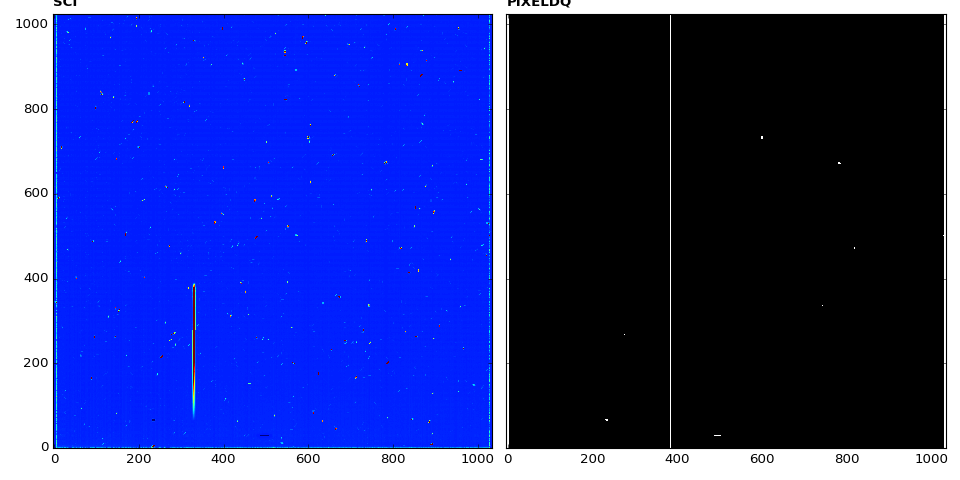

In [7]:
# plot--------------------------------------
%matplotlib notebook
from matplotlib.colors import LogNorm

# open the input image as a jwst data model
with datamodels.open(dq_init_output_file) as dm:
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    # show last frame of first integration
    axs[0].imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
    axs[0].annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

    # plot the PIXEL_DQ frame
    axs[1].imshow(dm.pixeldq, cmap='gray', interpolation='nearest', origin='lower', vmin=0, vmax=1)
    axs[1].annotate('PIXELDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

    plt.tight_layout()
    plt.show()
    

## SATURATION step ============================================
The saturation step flags saturated pixel for each integration by reading the calibration reference
file that specifies the saturation level for each pixel. The saturation flags are set in the fram of the GROUPDQ extension where the pixel reaches saturation. See:

http://ssb.stsci.edu/doc/jwst_git/docs/saturation/html/

We will define where we want the output written (removing any file from a previous run)

### SATURATION: load module and show options

In [8]:
# import the step
from jwst.saturation import saturation_step

# print the description and options
print saturation_step.SaturationStep.__doc__
print saturation_step.SaturationStep.spec

# set the output file name
saturation_output_file = os.path.join(output_dir,'%s_saturation.fits' % input_basename)

# delete output from a previous run
try: 
    os.remove(saturation_output_file)
except OSError:
    pass


    This Step sets saturation flags.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())

    output_dir = string(default=None) # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False) # Skip this step
    


### SATURATION: run step

In [9]:
# run the saturation step
saturation_step.SaturationStep.call(dq_init_output_file, output_file=saturation_output_file)

2017-02-16 10:59:44,907 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2017-02-16 10:59:46,610 - stpipe.SaturationStep - INFO - Prefetch for SATURATION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0019.fits'.
2017-02-16 10:59:46,681 - stpipe.SaturationStep - INFO - Step SaturationStep running with args ('det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_dq_init.fits',).
2017-02-16 10:59:47,359 - stpipe.SaturationStep - INFO - Using SATURATION reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_saturation_0019.fits
2017-02-16 10:59:48,872 - stpipe.SaturationStep - INFO - Saving file /Users/patrickkavanagh/mirisim/testing/lrssim/slit/det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_saturation.fits
2017-02-16 10:59:49,416 - stpipe.SaturationStep - INFO - Step SaturationStep done


### SATURATION:  output check

1. check the output fits file contains the calibration step information, look at the new extension table

2. saturated pixels will be flagged in the GROUPDQ extension with the number 2. Check that some pixels in this extension are now flagged as saturated

In [10]:
# check the output fits file information using astropy fits
with fits.open(saturation_output_file) as hdulist:
    
    # check the calibration step information
    print'Check saturation step information status:'
    step_check = hdulist[0].header['S_SATURA']
    print step_check + '\n'
    
    # print the fits extension table and properties
    hdulist.info()

# check the contents of the new DQ arrays using the datamodel
with datamodels.open(saturation_output_file) as dm:

    # print unique values in the GROUPDQ extension
    print "\nDQ flags values in GROUPDQ extension:"
    print ', '.join(map(str, np.unique(dm.groupdq)))
    

Check saturation step information status:
COMPLETE

Filename: det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_saturation.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     150   ()      
  1  SCI         ImageHDU        11   (1032, 1024, 15, 2)   float32   
  2  PIXELDQ     ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ     ImageHDU        10   (1032, 1024, 15, 2)   uint8   
  4  ERR         ImageHDU        10   (1032, 1024, 15, 2)   float32   
  5  REFOUT      ImageHDU        11   (258, 1024, 15, 2)   float32   
  6  ASDF        ImageHDU         7   (18145,)   uint8   
  7  PIXELDQ_DEF  BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   

DQ flags values in GROUPDQ extension:
0, 2


### SATURATION:  output plots

1. plot the science data

2. plot the GROUP_DQ extension to show which pixels have been flagged as saturated

<IPython.core.display.Javascript object>


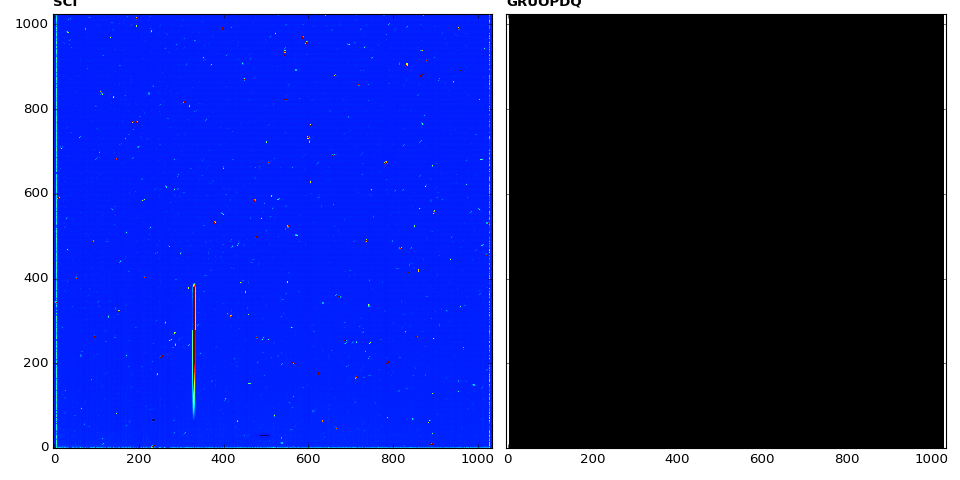

In [11]:
# plot--------------------------------------
%matplotlib notebook
from matplotlib.colors import LogNorm

# open the input image as a jwst data model
with datamodels.open(saturation_output_file) as dm:
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    # show last frame of first integration
    axs[0].imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
    axs[0].annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

    # plot last frame of first integration GROUP_DQ
    axs[1].imshow(np.sum(dm.groupdq[0],axis=0), cmap='gray', interpolation='nearest', origin='lower', vmin=0, vmax=1)
    axs[1].annotate('GRUOPDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

    plt.tight_layout()
    plt.show()
    

## IPC step ==================================================
In CDP5, it was recommended to ignore the IPC calibration. This will be skipped in future builds of the pipeline so we will ignore it here. For information on this step see:

http://ssb.stsci.edu/doc/jwst_git/docs/ipc/html/

## LINEARITY step ===============================================

This step corrects for detector non-linearity. The linearity coefficients are read from the linearity correction reference file.

http://ssb.stsci.edu/doc/jwst_git/docs/linearity/html/

We will define where we want the output written (removing any file from a previous run)

### LINEARITY: load module and show options

In [12]:
# import the step
from jwst.linearity import linearity_step

# print the description and options
print linearity_step.LinearityStep.__doc__
print linearity_step.LinearityStep.spec

# set the output file name
linearity_output_file = os.path.join(output_dir,'%s_linearity.fits' % input_basename)

# delete output from a previous run
try: 
    os.remove(linearity_output_file)
except OSError:
    pass


    LinearityStep: This step performs a correction for non-linear
    detector response, using the "classic" polynomial method.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())

    output_dir = string(default=None) # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False) # Skip this step
    


### LINEARITY: run step

In [13]:
# run the linearity step
linearity_step.LinearityStep.call(saturation_output_file, output_file=linearity_output_file)

2017-02-16 10:59:59,018 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2017-02-16 11:00:00,822 - stpipe.LinearityStep - INFO - Prefetch for LINEARITY reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0014.fits'.
2017-02-16 11:00:00,906 - stpipe.LinearityStep - INFO - Step LinearityStep running with args ('det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_saturation.fits',).
2017-02-16 11:00:01,640 - stpipe.LinearityStep - INFO - Using Linearity reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_linearity_0014.fits
2017-02-16 11:00:03,286 - stpipe.LinearityStep - INFO - Saving file /Users/patrickkavanagh/mirisim/testing/lrssim/slit/det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_linearity.fits
2017-02-16 11:00:03,828 - stpipe.LinearityStep - INFO - Step LinearityStep done


### LINEARITY:  output check

1. check the output fits file contains the calibration step information, look at the new extension table


In [14]:
# check the output fits file information using astropy fits
with fits.open(linearity_output_file) as hdulist:
    
    # check the calibration step information
    print'Check linearity step information status:'
    step_check = hdulist[0].header['S_LINEAR']
    print step_check + '\n'
    
    # print the fits extension table and properties
    hdulist.info()
    

Check linearity step information status:
COMPLETE

Filename: det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_linearity.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     155   ()      
  1  SCI         ImageHDU        11   (1032, 1024, 15, 2)   float32   
  2  PIXELDQ     ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ     ImageHDU        10   (1032, 1024, 15, 2)   uint8   
  4  ERR         ImageHDU        10   (1032, 1024, 15, 2)   float32   
  5  REFOUT      ImageHDU        11   (258, 1024, 15, 2)   float32   
  6  ASDF        ImageHDU         7   (18227,)   uint8   
  7  PIXELDQ_DEF  BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   


### LINEARITY:  plot output science image to select pixel for inspection

<IPython.core.display.Javascript object>


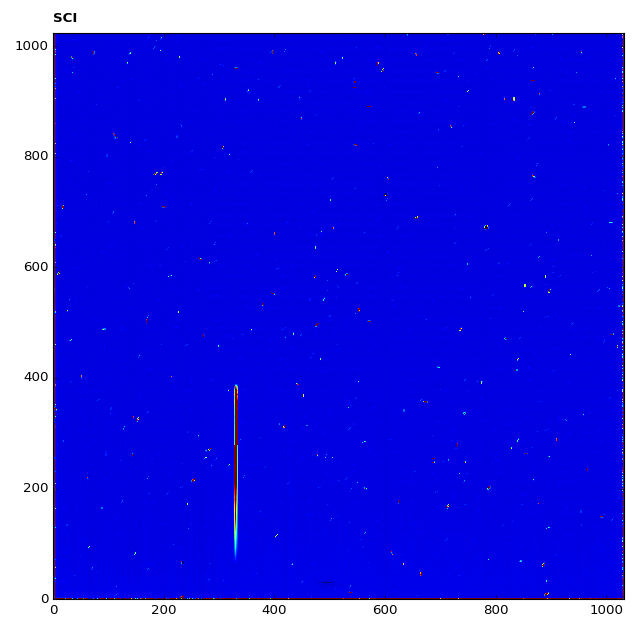

In [15]:
# plot--------------------------------------
%matplotlib notebook
from matplotlib.colors import LogNorm

# open the input image as a jwst data model
with datamodels.open(linearity_output_file) as dm:
    
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))

    # show last frame of first integration
    axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
    axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

    plt.tight_layout()
    plt.show()

### LINEARITY:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these

<IPython.core.display.Javascript object>


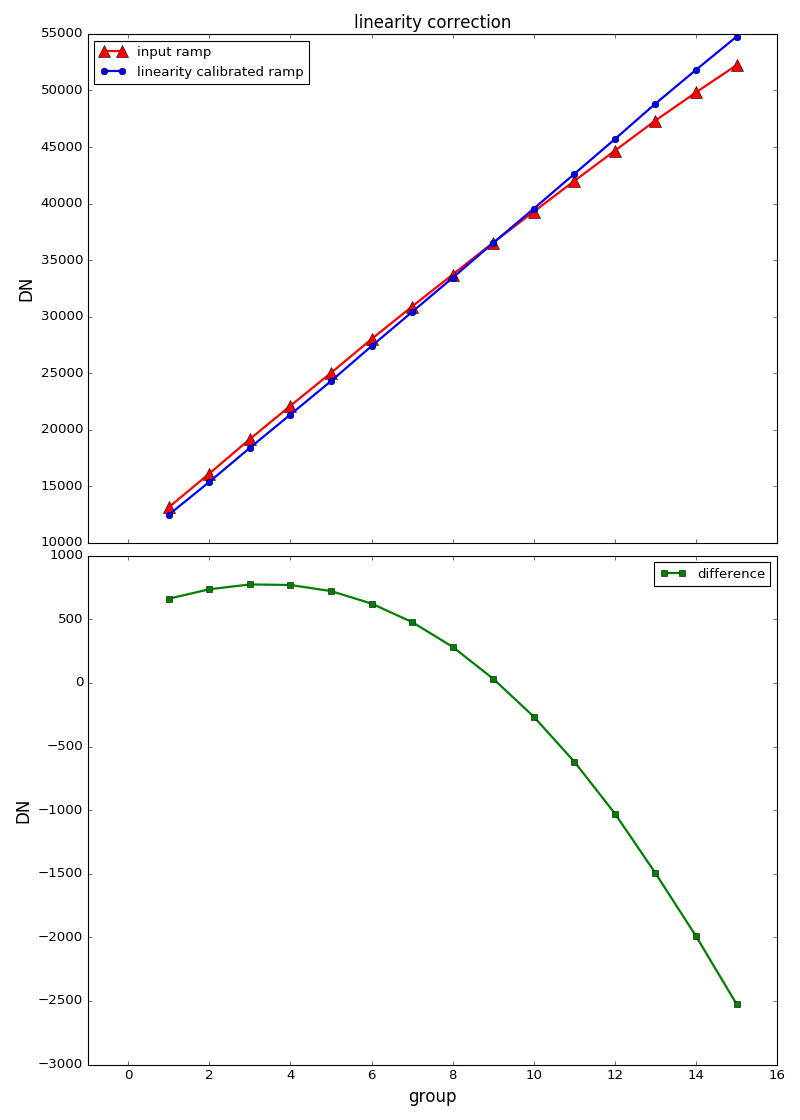

In [16]:
# using image in previous cell, select pixel to check
pixel = [331,297]

# open the input and output as jwst data models
with datamodels.open(saturation_output_file) as in_dm:
    with datamodels.open(linearity_output_file) as out_dm:

        # define group numbers for integration ramps
        group = range(1,in_dm.data[0,:,pixel[0],pixel[1]].shape[0]+1,1)

        # plot--------------------------------------
        %matplotlib notebook
        fig, axs = plt.subplots(2, 1, figsize=(10, 14), sharex=True)

        # plot input and output ramps of the first integration
        axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=10, linestyle='-', linewidth=2, label='input ramp')
        axs[0].plot(group, out_dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='linearity calibrated ramp')
        axs[0].set_title('linearity correction',fontsize=15)
        axs[0].set_ylabel('DN',fontsize=15)
        axs[0].set_xlim(-1,max(group)+1)
        axs[0].legend(prop={'size':12}, loc=0)

        # plot difference
        axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - out_dm.data[0,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
        axs[1].set_ylabel('DN',fontsize=15)
        axs[1].set_xlabel('group',fontsize=15)
        axs[1].legend(prop={'size':12}, loc=0)

        plt.tight_layout(h_pad=0)
        plt.show()



## RSCD step ======================================================
This step corrects for the slow adjustment of the reset FET to the asymtotic level after reset. See:

http://ssb.stsci.edu/doc/jwst_git/docs/rscd/html/

We will define where we want the output written (removing any file from a previous run)

### RSCD: load module and show options

In [17]:
# import the step
from jwst.rscd import rscd_step

# print the description and options
print rscd_step.RSCD_Step.__doc__
print rscd_step.RSCD_Step.spec

# set the output file name
rscd_output_file = os.path.join(output_dir,'%s_rscd.fits' % input_basename)

# delete output from a previous run
try: 
    os.remove(rscd_output_file)
except OSError:
    pass


    RSCD_Step: Performs an RSCD correction to MIRI data by adding a function
    of time, frame by frame, to a copy of the input science data model.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())

    output_dir = string(default=None) # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False) # Skip this step
    


#### RSCD: run step

In [18]:
# run the rscd step
rscd_step.RSCD_Step.call(linearity_output_file, output_file=rscd_output_file)

2017-02-16 11:00:19,621 - stpipe.RSCD_Step - INFO - RSCD_Step instance created.
2017-02-16 11:00:21,457 - stpipe.RSCD_Step - INFO - Prefetch for RSCD reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0004.fits'.
2017-02-16 11:00:21,550 - stpipe.RSCD_Step - INFO - Step RSCD_Step running with args ('det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_linearity.fits',).
2017-02-16 11:00:22,289 - stpipe.RSCD_Step - INFO - Using RSCD reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rscd_0004.fits
2017-02-16 11:00:56,603 - stpipe.RSCD_Step - INFO - Saving file /Users/patrickkavanagh/mirisim/testing/lrssim/slit/det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_rscd.fits
2017-02-16 11:00:57,344 - stpipe.RSCD_Step - INFO - Step RSCD_Step done


### RSCD:  output check

1. check the output fits file contains the calibration step information, look at the new extension table


In [19]:
# check the output fits file information using astropy fits
with fits.open(rscd_output_file) as hdulist:
    
    # check the calibration step information
    print'Check RSCD step information status:'
    step_check = hdulist[0].header['S_RSCD']
    print step_check + '\n'
    
    # print the fits extension table and properties
    hdulist.info()

Check RSCD step information status:
COMPLETE

Filename: det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_rscd.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     160   ()      
  1  SCI         ImageHDU        11   (1032, 1024, 15, 2)   float32   
  2  PIXELDQ     ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ     ImageHDU        10   (1032, 1024, 15, 2)   uint8   
  4  ERR         ImageHDU        10   (1032, 1024, 15, 2)   float32   
  5  REFOUT      ImageHDU        11   (258, 1024, 15, 2)   float32   
  6  ASDF        ImageHDU         7   (18290,)   uint8   
  7  PIXELDQ_DEF  BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   


### RSCD:  plot output science image to select pixel for inspection

<IPython.core.display.Javascript object>


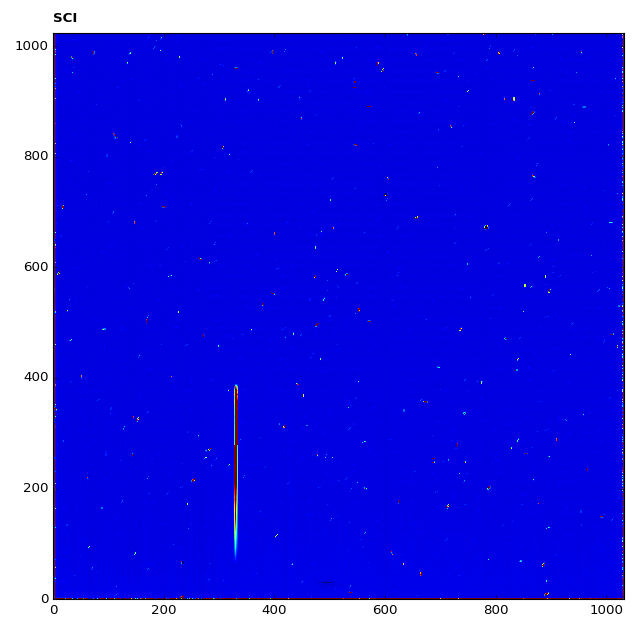

In [20]:
# plot--------------------------------------
%matplotlib notebook
from matplotlib.colors import LogNorm

# open the input image as a jwst data model
with datamodels.open(rscd_output_file) as dm:
    
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))

    # show last frame of first integration
    axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
    axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

    plt.tight_layout()
    plt.show()

### RSCD:  input/output ramp comparison

1. plot the input and output ramps. Note that the RSCD step only corrects following a reset show will note perform a correction if there is only one integration in the exposure.

2. show the difference between the input and output ramps


<IPython.core.display.Javascript object>


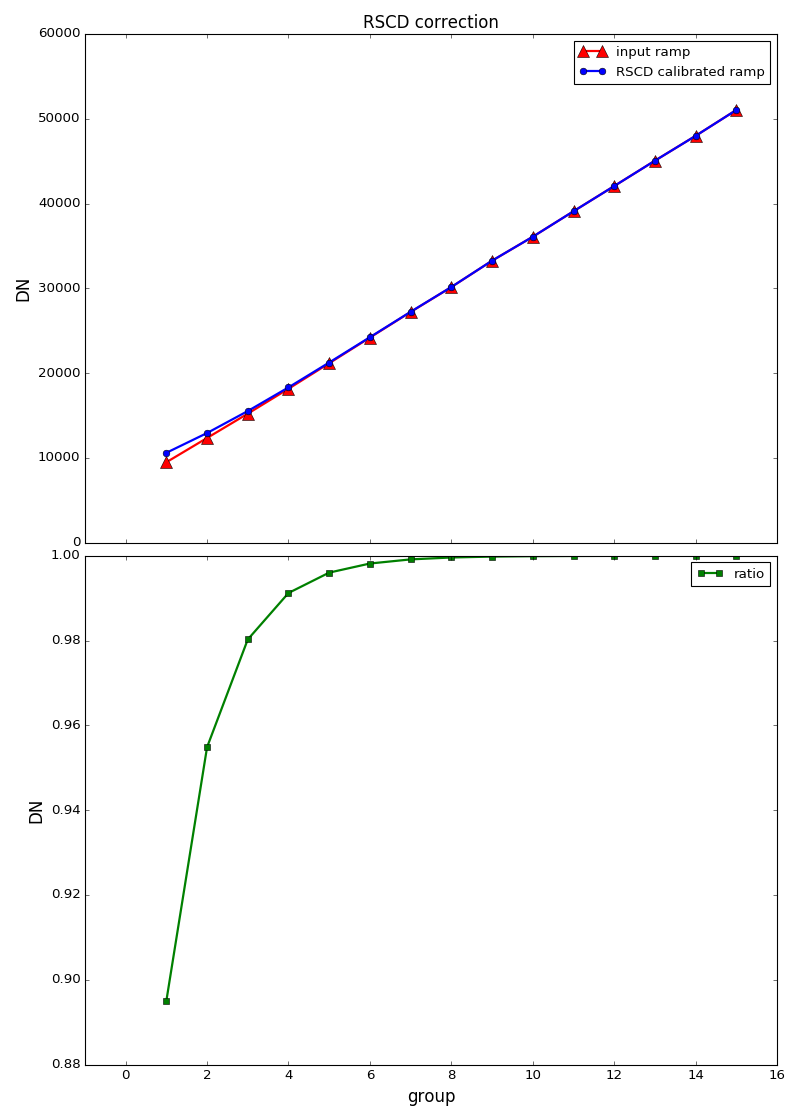

In [21]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# open the input and output as jwst data models
with datamodels.open(linearity_output_file) as in_dm:
    with datamodels.open(rscd_output_file) as out_dm:
            
        # first check that there is more than one integration
        if in_dm.data.shape[0] > 1:

            # define group numbers for integration ramps
            group = range(1,in_dm.data[0,:,pixel[0],pixel[1]].shape[0]+1,1)

            # plot--------------------------------------
            %matplotlib notebook
            fig, axs = plt.subplots(2, 1, figsize=(10, 14), sharex=True)

            # plot input and output ramps of the second integration
            axs[0].plot(group, in_dm.data[1,:,pixel[1],pixel[0]], c='r', marker='^', markersize=10, linestyle='-', linewidth=2, label='input ramp')
            axs[0].plot(group, out_dm.data[1,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='RSCD calibrated ramp')
            axs[0].set_title('RSCD correction',fontsize=15)
            axs[0].set_ylabel('DN',fontsize=15)
            axs[0].set_xlim(-1,max(group)+1)
            axs[0].legend(prop={'size':12}, loc=0)

            # plot ratio between the two
            axs[1].plot(group, in_dm.data[1,:,pixel[1],pixel[0]] / out_dm.data[1,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='ratio')
            axs[1].set_ylabel('DN',fontsize=15)
            axs[1].set_xlabel('group',fontsize=15)
            axs[1].legend(prop={'size':12}, loc=0)

            plt.tight_layout(h_pad=0)
            plt.show()

        else: print "RSCD step only operates on exposures with more than one integration."


## LASTFRAME step ==========================================
This step corrects for the anonolous offsets in the last frame of an integration due to the way MIRI detectors reset sequentially. See:

http://ssb.stsci.edu/doc/jwst_git/docs/lastframe/html/

We will define where we want the output written (removing any file from a previous run)

### LASTFRAME: load module and show options

In [22]:
# import the step
from jwst.lastframe import lastframe_step

# print the description and options
print lastframe_step.LastFrameStep.__doc__
print lastframe_step.LastFrameStep.spec

# set the output file name
lastframe_output_file = os.path.join(output_dir,'%s_lastframe.fits' % input_basename)

# delete output from a previous run
try: 
    os.remove(lastframe_output_file)
except OSError:
    pass


    LastFrameStep: This is a MIRI specific task.  If the number of groups
    is greater than 1, the GROUP data quality flags for the final group will
    be set to DO_NOT_USE.
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())

    output_dir = string(default=None) # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False) # Skip this step
    


### LASTFRAME: run step

In [23]:
# run the lastframe step
lastframe_step.LastFrameStep.call(rscd_output_file, output_file=lastframe_output_file)

2017-02-16 11:02:28,860 - stpipe.LastFrameStep - INFO - LastFrameStep instance created.
2017-02-16 11:02:30,107 - stpipe.LastFrameStep - INFO - Step LastFrameStep running with args ('det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_rscd.fits',).
2017-02-16 11:02:30,627 - stpipe.LastFrameStep - INFO - Saving file /Users/patrickkavanagh/mirisim/testing/lrssim/slit/det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_lastframe.fits
2017-02-16 11:02:31,173 - stpipe.LastFrameStep - INFO - Step LastFrameStep done


### LASTFRAME:  output check

1. check the output fits file contains the calibration step information, look at the new extension table

In [24]:
# check the output fits file information using astropy fits
with fits.open(lastframe_output_file) as hdulist:
    
    # check the calibration step information
    print'Check lastframe step information status:'
    step_check = hdulist[0].header['S_LASTFR']
    print step_check + '\n'
    
    # print the fits extension table and properties
    hdulist.info()

Check lastframe step information status:
COMPLETE

Filename: det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_lastframe.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     161   ()      
  1  SCI         ImageHDU        11   (1032, 1024, 15, 2)   float32   
  2  PIXELDQ     ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ     ImageHDU        10   (1032, 1024, 15, 2)   uint8   
  4  ERR         ImageHDU        10   (1032, 1024, 15, 2)   float32   
  5  REFOUT      ImageHDU        11   (258, 1024, 15, 2)   float32   
  6  ASDF        ImageHDU         7   (18320,)   uint8   
  7  PIXELDQ_DEF  BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   


### LASTFRAME:  input/output ramp comparison

This correction flags the last frame of an integration so we can check that the last frame has indeed been flagged in the groupDQ extension.

1. plot the last frame of the first integration of the GROUPDQ extension, show values of flags (should be solid colour)

2. plot the input and output GROUPDQ to show that last frame has been flagged

<IPython.core.display.Javascript object>


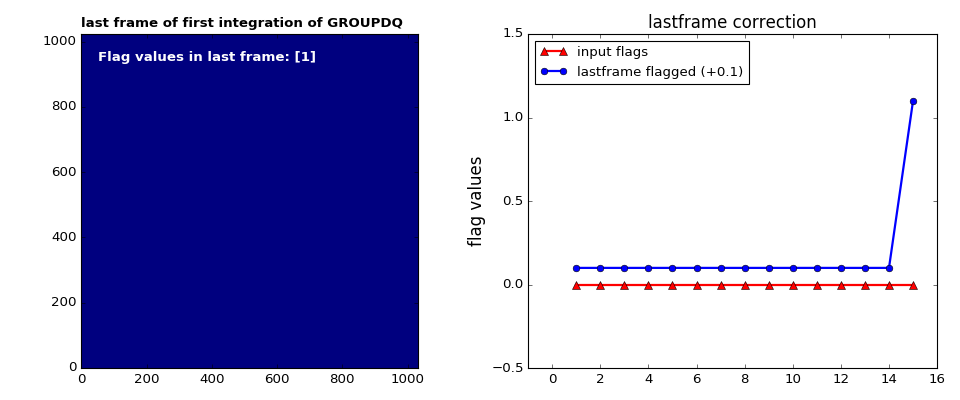

In [25]:
# define an input and output integration ramp for a given pixel
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# open the input and output as jwst data models
with datamodels.open(rscd_output_file) as in_dm:
    with datamodels.open(lastframe_output_file) as out_dm:

        # define group numbers for integration ramps
        group = range(1,in_dm.data[0,:,pixel[0],pixel[1]].shape[0]+1,1)

        # plot--------------------------------------
        %matplotlib notebook
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        # plot the last frame of the first integration of the GROUPDQ extension
        axs[0].imshow(out_dm.groupdq[0][-1], cmap='jet', interpolation='nearest', origin='lower')
        axs[0].annotate('last frame of first integration of GROUPDQ', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        
        # determine the values in this GROUPDQ frame
        flag_values = np.unique(out_dm.groupdq[0][-1])
        axs[0].annotate('Flag values in last frame: %s' % flag_values, xy=(0.05, 0.92), xycoords='axes fraction', fontsize=12, fontweight='bold', color='w')

        # input and output ramps (setting a slight offset for the output ramp)
        axs[1].plot(group, in_dm.groupdq[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=7, linestyle='-', linewidth=2, label='input flags')
        axs[1].plot(group, out_dm.groupdq[0,:,pixel[1],pixel[0]]+0.1, c='b', marker='o', linestyle='-', linewidth=2, label='lastframe flagged (+0.1)')
        axs[1].set_title('lastframe correction',fontsize=15)
        axs[1].set_ylabel('flag values',fontsize=15)
        axs[1].set_xlim(-1,max(group)+1)
        axs[1].set_ylim(-0.5,1.5)
        axs[1].legend(prop={'size':12}, loc=2)

        plt.tight_layout(h_pad=0)
        plt.show()



## DARK_CURRENT step ==========================================

This step removes the dark current by subtracting a dark current reference file.

http://ssb.stsci.edu/doc/jwst_git/docs/dark_current/html/

We will define where we want the output written (removing any file from a previous run)

### DARK_CURRENT: load module and show options

In [26]:
# import the step
from jwst.dark_current import dark_current_step

# print the description and options
print dark_current_step.DarkCurrentStep.__doc__
print dark_current_step.DarkCurrentStep.spec

# set the output file name
dark_current_output_file = os.path.join(output_dir,'%s_dark_current.fits' % input_basename)

# delete output from a previous run
try: 
    os.remove(dark_current_output_file)
except OSError:
    pass


    DarkCurrentStep: Performs dark current correction by subtracting
    dark current reference data from the input science data model.
    

        dark_output = output_file(default = None)
    


### DARK_CURRENT: run step

In [27]:
# run the dark_current step
dark_current_step.DarkCurrentStep.call(lastframe_output_file, output_file=dark_current_output_file)

2017-02-16 11:02:38,502 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2017-02-16 11:02:40,571 - stpipe.DarkCurrentStep - INFO - Prefetch for DARK reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_dark_0058.fits'.
2017-02-16 11:02:40,682 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args ('det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_lastframe.fits',).
2017-02-16 11:02:41,483 - stpipe.DarkCurrentStep - INFO - Using DARK reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_dark_0058.fits
2017-02-16 11:02:41,698 - stpipe.DarkCurrentStep - INFO - Science data nints=2, ngroups=15, nframes=1, groupgap=0
2017-02-16 11:02:41,699 - stpipe.DarkCurrentStep - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0
2017-02-16 11:02:47,837 - stpipe.DarkCurrentStep - INFO - Saving file /Users/patrickkavanagh/mirisim/testing/lrssim/slit/det_image_1_MIRIMAGE_P750L

### DARK_CURRENT:  output check

1. check the output fits file contains the calibration step information, look at the new extension table

In [28]:
# check the output fits file information using astropy fits
with fits.open(dark_current_output_file) as hdulist:
    
    # check the calibration step information
    print'Check dark_current step information status:'
    step_check = hdulist[0].header['S_DARK']
    print step_check + '\n'
    
    # print the fits extension table and properties
    hdulist.info()

Check dark_current step information status:
COMPLETE

Filename: det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_dark_current.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     166   ()      
  1  SCI         ImageHDU        11   (1032, 1024, 15, 2)   float32   
  2  PIXELDQ     ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ     ImageHDU        10   (1032, 1024, 15, 2)   uint8   
  4  ERR         ImageHDU        10   (1032, 1024, 15, 2)   float32   
  5  REFOUT      ImageHDU        11   (258, 1024, 15, 2)   float32   
  6  ASDF        ImageHDU         7   (18395,)   uint8   
  7  PIXELDQ_DEF  BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   


### DARK_CURRENT:  plot output science image to select pixel for inspection

<IPython.core.display.Javascript object>


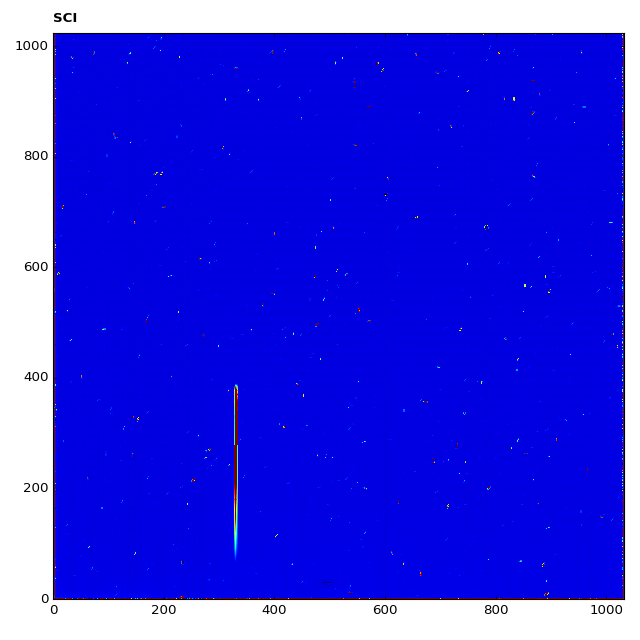

In [29]:
# plot--------------------------------------
%matplotlib notebook
from matplotlib.colors import LogNorm

# open the input image as a jwst data model
with datamodels.open(dark_current_output_file) as dm:
    
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))

    # show last frame of first integration
    axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
    axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

    plt.tight_layout()
    plt.show()

### DARK_CURRENT:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these


<IPython.core.display.Javascript object>


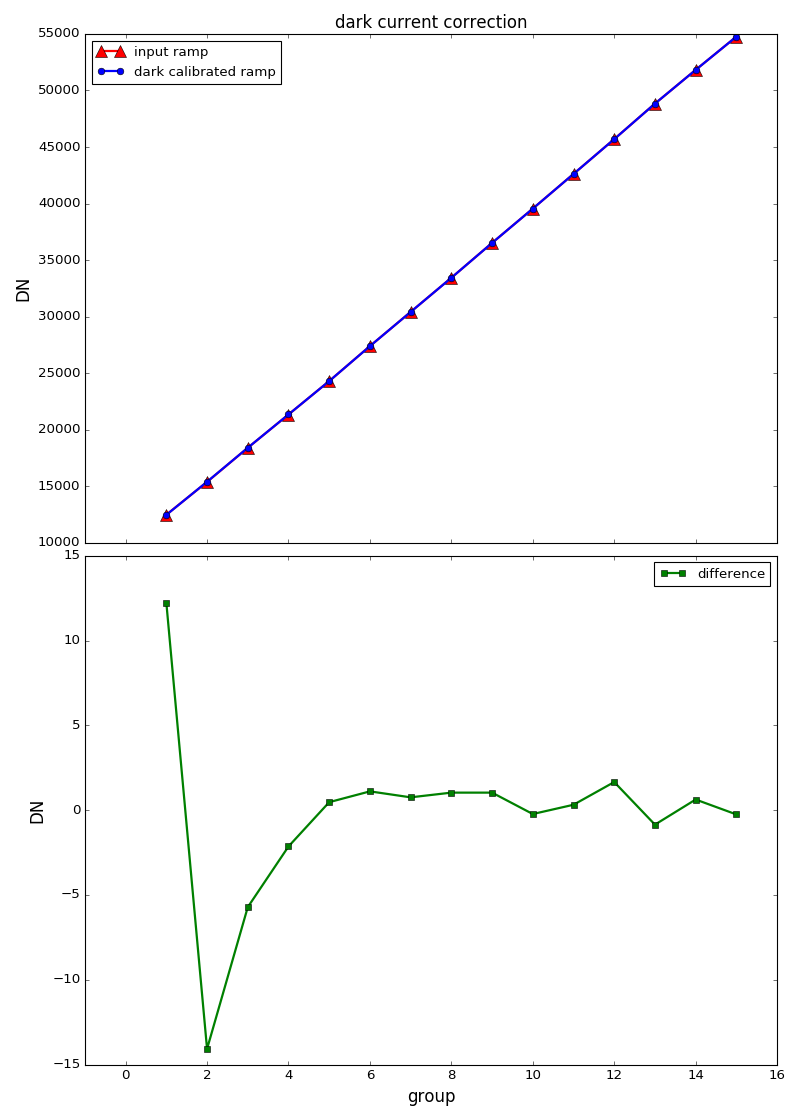

In [30]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# open the input and output as jwst data models
with datamodels.open(lastframe_output_file) as in_dm:
    with datamodels.open(dark_current_output_file) as out_dm:
            
        # define group numbers for integration ramps
        group = range(1,in_dm.data[0,:,pixel[0],pixel[1]].shape[0]+1,1)

        # plot--------------------------------------
        %matplotlib notebook
        fig, axs = plt.subplots(2, 1, figsize=(10, 14), sharex=True)

        # plot input and output ramps of the second integration
        axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=10, linestyle='-', linewidth=2, label='input ramp')
        axs[0].plot(group, out_dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='dark calibrated ramp')
        axs[0].set_title('dark current correction',fontsize=15)
        axs[0].set_ylabel('DN',fontsize=15)
        axs[0].set_xlim(-1,max(group)+1)
        axs[0].legend(prop={'size':12}, loc=0)

        # plot difference between the two
        axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - out_dm.data[0,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
        axs[1].set_ylabel('DN',fontsize=15)
        axs[1].set_xlabel('group',fontsize=15)
        axs[1].legend(prop={'size':12}, loc=0)

        plt.tight_layout(h_pad=0)
        plt.show()

## REFPIX step =============================================
This step corrects for electronic drift effects in the data by applying the reference pixel correction. See:

http://ssb.stsci.edu/doc/jwst_git/docs/refpix/html/

We will define where we want the output written (removing any file from a previous run)
The input file is the saturation step output

### REFPIX: load module and show options

In [31]:
# import the step
from jwst.refpix import refpix_step

# print the description and options
print refpix_step.RefPixStep.__doc__
print refpix_step.RefPixStep.spec

# set the output file name
refpix_output_file = os.path.join(output_dir,'%s_refpix.fits' % input_basename)

# delete output from a previous run
try: 
    os.remove(refpix_output_file)
except OSError:
    pass



    RefPixStep: Use reference pixels to correct bias drifts

    

        odd_even_columns = boolean(default=True)
        use_side_ref_pixels = boolean(default=True)
        side_smoothing_length = integer(default=11)
        side_gain = float(default=1.0)
        odd_even_rows = boolean(default=True)
    


### REFPIX: run step

In [32]:
# run the refpix step
refpix_step.RefPixStep.call(dark_current_output_file, output_file=refpix_output_file)

2017-02-16 11:09:07,341 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2017-02-16 11:09:09,605 - stpipe.RefPixStep - INFO - Prefetch for REFPIX reference file is 'N/A'.
2017-02-16 11:09:09,743 - stpipe.RefPixStep - INFO - Step RefPixStep running with args ('det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_dark_current.fits',).
2017-02-16 11:09:09,945 - stpipe.RefPixStep - INFO - use_side_ref_pixels = True
2017-02-16 11:09:09,946 - stpipe.RefPixStep - INFO - odd_even_columns = True
2017-02-16 11:09:09,947 - stpipe.RefPixStep - INFO - side_smoothing_length = 11
2017-02-16 11:09:09,947 - stpipe.RefPixStep - INFO - side_gain = 1.000000
2017-02-16 11:09:09,948 - stpipe.RefPixStep - INFO - odd_even_rows = True
2017-02-16 11:09:09,949 - stpipe.RefPixStep - INFO - Subtracting initial read from each integration
2017-02-16 11:09:10,483 - stpipe.RefPixStep - INFO - Adding initial read back in
2017-02-16 11:09:10,971 - stpipe.RefPixStep - INFO - Saving file /Use

### REFPIX:  output quick check

1. check the output fits file contains the calibration step information, look at the new extension table

In [33]:
# check the output fits file information using astropy fits
with fits.open(refpix_output_file) as hdulist:
    
    # check the calibration step information
    print'Check refpix step information status:'
    step_check = hdulist[0].header['S_REFPIX']
    print step_check + '\n'
    
    # print the fits extension table and properties
    hdulist.info()

Check refpix step information status:
COMPLETE

Filename: det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_refpix.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     167   ()      
  1  SCI         ImageHDU        11   (1032, 1024, 15, 2)   float32   
  2  PIXELDQ     ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ     ImageHDU        10   (1032, 1024, 15, 2)   uint8   
  4  ERR         ImageHDU        10   (1032, 1024, 15, 2)   float32   
  5  REFOUT      ImageHDU        11   (258, 1024, 15, 2)   float32   
  6  ASDF        ImageHDU         7   (18407,)   uint8   
  7  PIXELDQ_DEF  BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   


### REFPIX:  plot output science image to select pixel for inspection

<IPython.core.display.Javascript object>


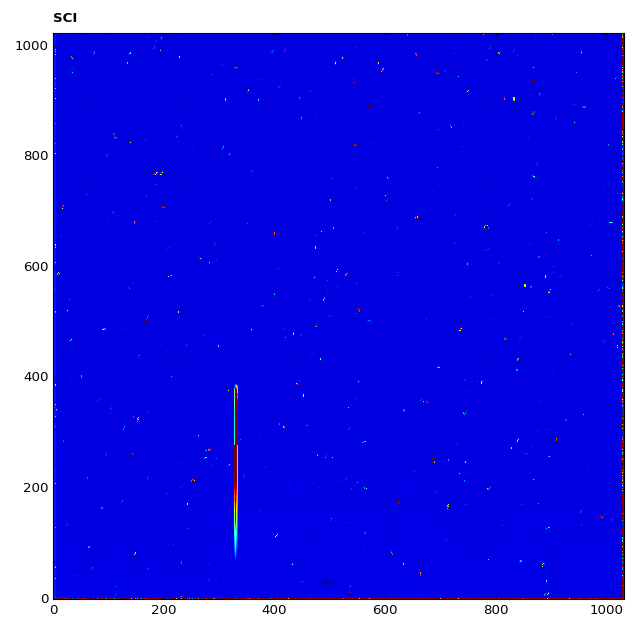

In [34]:
# plot--------------------------------------
%matplotlib notebook
from matplotlib.colors import LogNorm

# open the input image as a jwst data model
with datamodels.open(refpix_output_file) as dm:
    
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))

    # show last frame of first integration
    axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
    axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

    plt.tight_layout()
    plt.show()

### REFPIX:  input/output ramp comparison

1. plot the input and output ramps

2. show the difference between these


<IPython.core.display.Javascript object>


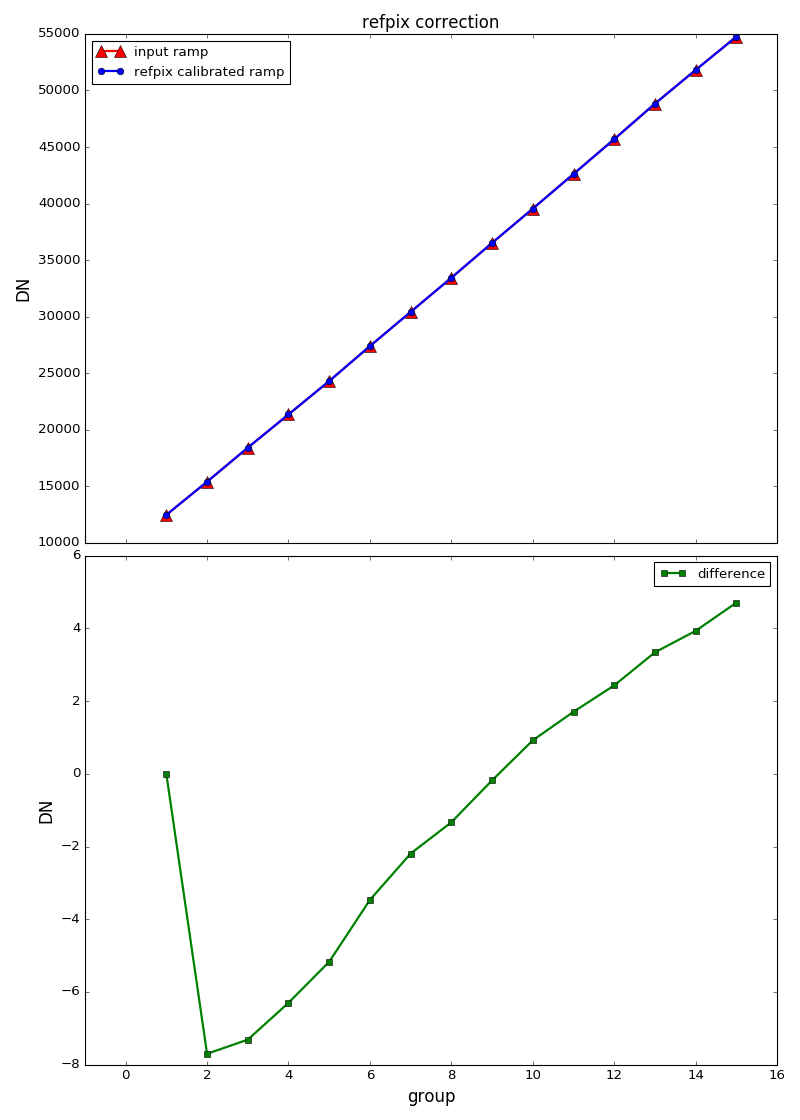

In [35]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# open the input and output as jwst data models
with datamodels.open(dark_current_output_file) as in_dm:
    with datamodels.open(refpix_output_file) as out_dm:
            
        # define group numbers for integration ramps
        group = range(1,in_dm.data[0,:,pixel[0],pixel[1]].shape[0]+1,1)

        # plot--------------------------------------
        %matplotlib notebook
        fig, axs = plt.subplots(2, 1, figsize=(10, 14), sharex=True)

        # plot input and output ramps of the second integration
        axs[0].plot(group, in_dm.data[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=10, linestyle='-', linewidth=2, label='input ramp')
        axs[0].plot(group, out_dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='refpix calibrated ramp')
        axs[0].set_title('refpix correction',fontsize=15)
        axs[0].set_ylabel('DN',fontsize=15)
        axs[0].set_xlim(-1,max(group)+1)
        axs[0].legend(prop={'size':12}, loc=0)

        # plot difference between the two
        axs[1].plot(group, in_dm.data[0,:,pixel[1],pixel[0]] - out_dm.data[0,:,pixel[1],pixel[0]], c='g', marker='s', markersize=6, linestyle='-', linewidth=2, label='difference')
        axs[1].set_ylabel('DN',fontsize=15)
        axs[1].set_xlabel('group',fontsize=15)
        axs[1].legend(prop={'size':12}, loc=0)

        plt.tight_layout(h_pad=0)
        plt.show()

## PERSISTENCE step (No-op) ====================================

This step will correct for bright source persistence signal in the detector and in the end may not be applied to MIRI data. It is currently a no-op step so we can skip it. See:

http://ssb.stsci.edu/doc/jwst_git/docs/persistence/html/

## JUMP correction =================================================

This step detects jumps in the ramp by looking for outliers from the ramp. It updates the GROUPDQ array to indicate where a jump was found.

http://ssb.stsci.edu/doc/jwst_git/docs/jump/html/

We will define where we want the output written (removing any file from a previous run)

### JUMP: load module and show options

In [36]:
# import the step
from jwst.jump import jump_step

# print the description and options
print jump_step.JumpStep.__doc__
print jump_step.JumpStep.spec

# set the output file name
jump_output_file = os.path.join(output_dir,'%s_jump.fits' % input_basename)

# delete output from a previous run
try: 
    os.remove(jump_output_file)
except OSError:
    pass


    JumpStep: Performs CR/jump detection on each ramp integration within an
    exposure. The 2-point difference method is applied on a first pass to all
    of the data. The y-intercept method is then applied in a second pass to
    only those pixels that have signal levels in the readout noise regime.
    

        rejection_threshold = float(default=4.0,min=0) # CR rejection threshold
        do_yintercept = boolean(default=False) # do y-intercept method?
        yint_threshold = float(default=1.0,min=0) # y-intercept signal threshold
    


### JUMP: run step

In [37]:
# run the jump step
jump_step.JumpStep.call(refpix_output_file, output_file=jump_output_file)

2017-02-16 11:09:22,876 - stpipe.JumpStep - INFO - JumpStep instance created.
2017-02-16 11:09:25,023 - stpipe.JumpStep - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-02-16 11:09:25,024 - stpipe.JumpStep - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2017-02-16 11:09:25,150 - stpipe.JumpStep - INFO - Step JumpStep running with args ('det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_refpix.fits',).
2017-02-16 11:09:25,369 - stpipe.JumpStep - INFO - CR rejection threshold = 4 sigma
2017-02-16 11:09:26,055 - stpipe.JumpStep - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2017-02-16 11:09:26,698 - stpipe.JumpStep - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_rea

### JUMP:  output check

1. check the output fits file contains the calibration step information, look at the new extension table

In [38]:
# check the output fits file information using astropy fits
with fits.open(jump_output_file) as hdulist:
    
    # check the calibration step information
    print'Check jump step information status:'
    step_check = hdulist[0].header['S_JUMP']
    print step_check + '\n'
    
    # print the fits extension table and properties
    hdulist.info()

Check jump step information status:
COMPLETE

Filename: det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_jump.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     176   ()      
  1  SCI         ImageHDU        11   (1032, 1024, 15, 2)   float32   
  2  PIXELDQ     ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  3  GROUPDQ     ImageHDU        10   (1032, 1024, 15, 2)   uint8   
  4  ERR         ImageHDU        10   (1032, 1024, 15, 2)   float32   
  5  REFOUT      ImageHDU        11   (258, 1024, 15, 2)   float32   
  6  ASDF        ImageHDU         7   (18535,)   uint8   
  7  PIXELDQ_DEF  BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   


### JUMP:  plot output science image to select pixel for inspection

<IPython.core.display.Javascript object>


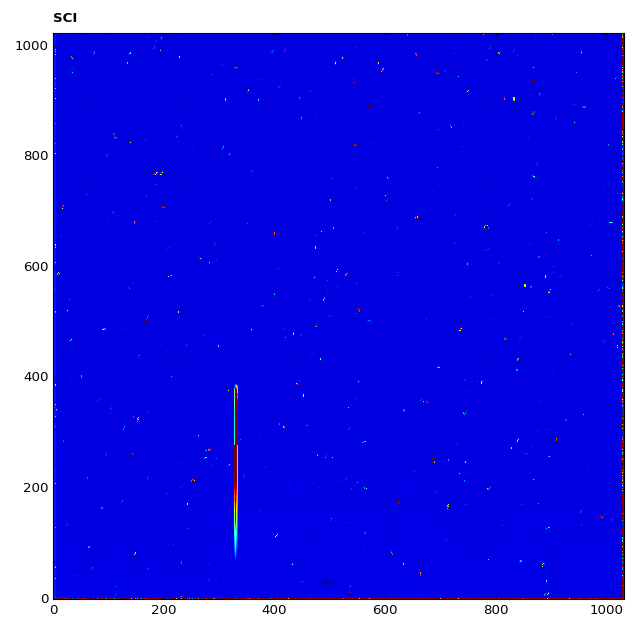

In [39]:
# plot--------------------------------------
%matplotlib notebook
from matplotlib.colors import LogNorm

# open the input image as a jwst data model
with datamodels.open(jump_output_file) as dm:
    
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))

    # show last frame of first integration
    axs.imshow(dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
    axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

    plt.tight_layout()
    plt.show()

### JUMP:  input/output ramp comparison

1. plot the output ramp

2. show the input and output GROUPDQ vectors and mark where jumps were detected (a flag of >=4 in GROUPDQ)


<IPython.core.display.Javascript object>


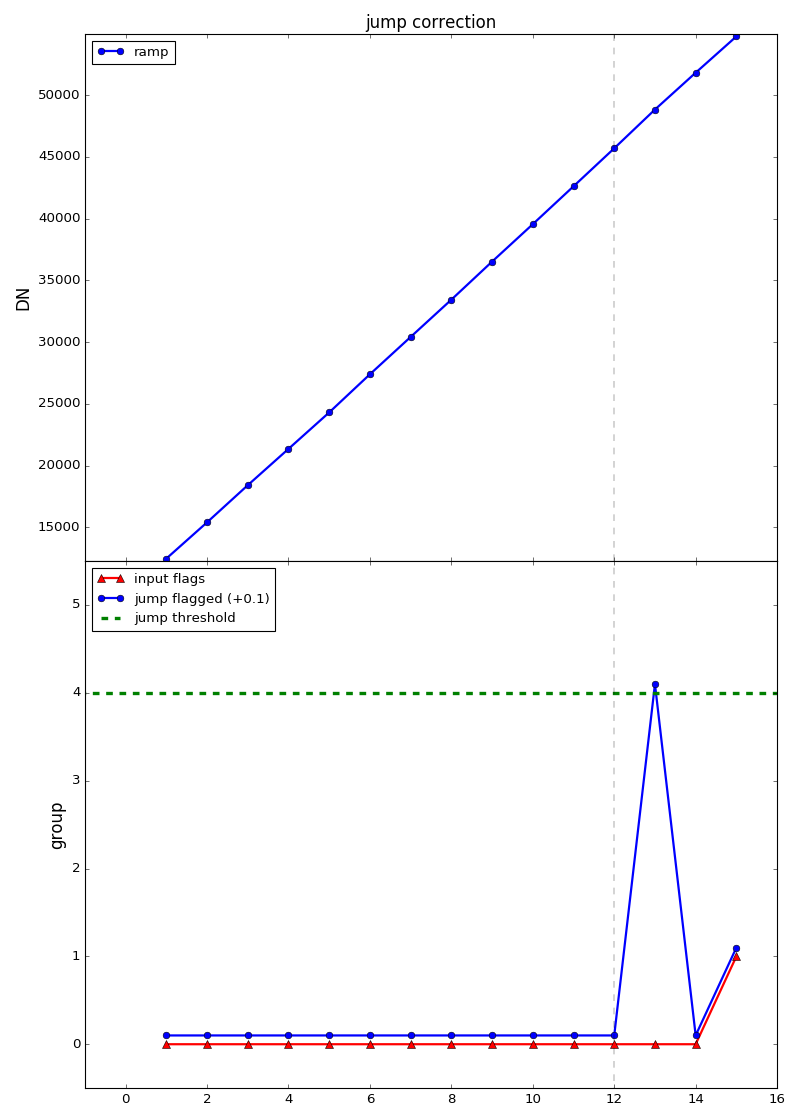

In [40]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# open the input and output as jwst data models
with datamodels.open(refpix_output_file) as in_dm:
    with datamodels.open(jump_output_file) as out_dm:
            
        # define group numbers for integration ramps
        group = range(1,in_dm.data[0,:,pixel[0],pixel[1]].shape[0]+1,1)

        # plot--------------------------------------
        %matplotlib notebook
        fig, axs = plt.subplots(2, 1, figsize=(10, 14), sharex=True)

        # first integration for input/output ramps
        axs[0].plot(group, out_dm.data[0,:,pixel[1],pixel[0]], c='b', marker='o', linestyle='-', linewidth=2, label='ramp')
        axs[0].set_title('jump correction',fontsize=15)
        axs[0].set_ylabel('DN',fontsize=15)
        axs[0].set_xlim(-1,max(group)+1)
        axs[0].set_ylim(min(out_dm.data[0,:,pixel[1],pixel[0]])-200,max(out_dm.data[0,:,pixel[1],pixel[0]])+200)
        axs[0].legend(prop={'size':12}, loc=2)

        # input and output flag values (setting a slight offset for the output flags)
        axs[1].plot(group, in_dm.groupdq[0,:,pixel[1],pixel[0]], c='r', marker='^', markersize=7, linestyle='-', linewidth=2, label='input flags')
        axs[1].plot(group, out_dm.groupdq[0,:,pixel[1],pixel[0]]+0.1, c='b', marker='o', linestyle='-', linewidth=2, label='jump flagged (+0.1)')
        axs[1].plot([-10,100],[4,4], linestyle='--', linewidth=3, c='g', label='jump threshold')
        axs[1].set_ylabel('flag values',fontsize=15)
        axs[1].set_ylabel('group',fontsize=15)
        axs[1].set_xlim(-1,max(group)+1)
        axs[1].set_ylim(-0.5,5.5)
        axs[1].legend(prop={'size':12}, loc=2)

        # draw lines to show the groups which have been flagged as jumps
        for n, val in enumerate(group):
            if (out_dm.groupdq[0,n,pixel[1],pixel[0]] >= 4): 
                axs[0].plot([n,n],[min(out_dm.data[0,:,pixel[1],pixel[0]])-200,max(out_dm.data[0,:,pixel[1],pixel[0]])+200], linestyle='--', linewidth=0.3, c='k')
                axs[1].plot([n,n],[-1,6], linestyle='--', linewidth=0.3, c='k')

        plt.tight_layout(h_pad=0)
        plt.show()


## RAMP_FITTING step =========================================

This step caculates the mean count rate for each pixel by performing a linear fit to the ramps. See:

http://ssb.stsci.edu/doc/jwst_git/docs/ramp_fitting/html/

There are two outputs are here:

1) the slope image  (_rate.fits)

2) if more than one integration, slope image per integration  (_rateints.fits)

We will define where we want the outputs written (removing any files from a previous run). This is the last step in the level 2a pipeline so we adjust the output file names to reflect this.

### RAMP_FITTING: load module and show options

In [41]:
# import the step
from jwst.ramp_fitting import ramp_fit_step

# print the description and options
print ramp_fit_step.RampFitStep.__doc__
print ramp_fit_step.RampFitStep.spec

# set the output file name
ramp_fitting_output_file = os.path.join(output_dir,'%s_rate.fits' % input_basename)
ramp_fitting_int_output_file = os.path.join(output_dir,'%s_rateints.fits' % input_basename)

# delete output from a previous run
try:
    os.remove(ramp_fitting_output_file)
    os.remove(ramp_fitting_int_output_file)
except OSError:
    pass


    This step fits a straight line to the value of counts vs. time to
    determine the mean count rate for each pixel.
    

        int_name = string(default='')
        save_opt = boolean(default=False) # Save optional output
        opt_name = string(default='')
        algorithm = option('OLS', 'GLS', default='OLS') # 'OLS' or 'GLS'
        weighting = option('unweighted', 'optimal', default='unweighted')         # 'unweighted' or 'optimal'
    


### RAMP_FITTING: run step

In [42]:
# run the ramp_fitting step
ramp_fit_step.RampFitStep.call(jump_output_file, output_file=ramp_fitting_output_file, save_opt=True, opt_name=ramp_fitting_int_output_file)

2017-02-16 11:18:34,061 - stpipe.RampFitStep - INFO - RampFitStep instance created.
2017-02-16 11:18:36,138 - stpipe.RampFitStep - INFO - Prefetch for GAIN reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits'.
2017-02-16 11:18:36,139 - stpipe.RampFitStep - INFO - Prefetch for READNOISE reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits'.
2017-02-16 11:18:36,271 - stpipe.RampFitStep - INFO - Step RampFitStep running with args ('det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_jump.fits',).
2017-02-16 11:18:37,723 - stpipe.RampFitStep - INFO - Using READNOISE reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_readnoise_0040.fits
2017-02-16 11:18:37,802 - stpipe.RampFitStep - INFO - Using GAIN reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_gain_0008.fits
2017-02-16 11:18:37,884 - stpipe.RampFitStep 

### RAMP_FITTING:  output check

1. check the output fits file contains the calibration step information, look at the new extension table

In [43]:
# check the output fits file information using astropy fits
with fits.open(ramp_fitting_output_file) as hdulist:
    
    # check the calibration step information
    print'Check ramp_fitting step information status:'
    step_check = hdulist[0].header['S_RAMP']
    print step_check + '\n'
    
    # print the fits extension table and properties
    hdulist.info()

Check ramp_fitting step information status:
COMPLETE

Filename: det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_rate.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     167   ()      
  1  SCI         ImageHDU         9   (1032, 1024)   float32   
  2  DQ          ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  3  ERR         ImageHDU         8   (1032, 1024)   float32   
  4  ASDF        ImageHDU         7   (4585,)   uint8   


### RAMP_FITTING:  level 1B and level 2A image comparison

Visually compare the input ramp and the output slope image

<IPython.core.display.Javascript object>


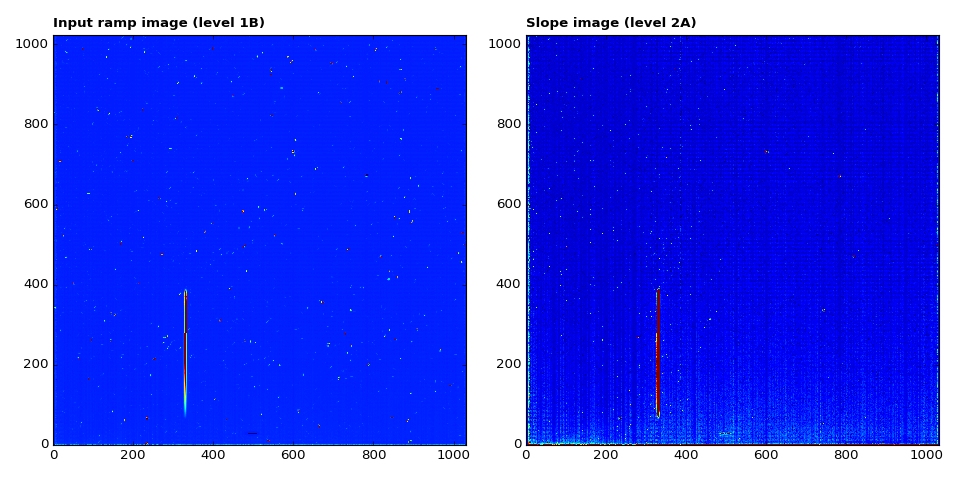

In [44]:
# open the input and output image as jwst data models
with datamodels.open(dq_init_output_file) as in_dm:
    with datamodels.open(ramp_fitting_output_file) as out_dm:

        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image.
        %matplotlib notebook
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
        axs[0].annotate('Input ramp image (level 1B)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_axis_bgcolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
        axs[1].annotate('Slope image (level 2A)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_axis_bgcolor('black')

        plt.tight_layout()
        plt.show()
    

## ASSIGN_WCS step =================================================
This step creates a WCS object and associates it with the science file, mapping detector to world coordinates. See:

http://ssb.stsci.edu/doc/jwst_git/docs/assign_wcs/html/

We will define where we want the output written (removing any file from a previous run)

In [45]:
# import the step
from jwst.assign_wcs import assign_wcs_step

# print the description and options
print assign_wcs_step.AssignWcsStep.__doc__
print assign_wcs_step.AssignWcsStep.spec

# set the output file name
assign_wcs_output_file = os.path.join(output_dir,'%s_assign_wcs.fits' % input_basename)

# delete output from a previous run
try:
    os.remove(assign_wcs_output_file)
except OSError:
    pass


    AssignWcsStep: Loads all WCS and distortion information for an exposure
    and stores it in the model meta data.
    

    


### ASSIGN_WCS: run step

In [46]:
# run the assign_wcs step
assign_wcs_step.AssignWcsStep.call(ramp_fitting_output_file, output_file=assign_wcs_output_file)

2017-02-16 11:25:42,276 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2017-02-16 11:25:43,131 - stpipe.AssignWcsStep - INFO - Prefetch for CAMERA reference file is 'N/A'.
2017-02-16 11:25:43,132 - stpipe.AssignWcsStep - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2017-02-16 11:25:43,133 - stpipe.AssignWcsStep - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2017-02-16 11:25:43,134 - stpipe.AssignWcsStep - INFO - Prefetch for DISTORTION reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_distortion_0020.asdf'.
2017-02-16 11:25:43,134 - stpipe.AssignWcsStep - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.
2017-02-16 11:25:43,135 - stpipe.AssignWcsStep - INFO - Prefetch for FORE reference file is 'N/A'.
2017-02-16 11:25:43,136 - stpipe.AssignWcsStep - INFO - Prefetch for FPA reference file is 'N/A'.
2017-02-16 11:25:43,137 - stpipe.AssignWcsStep - INFO - Prefetch for IFUFORE reference file is 'N/A'.
2017-02-

### ASSIGN_WCS: output check

1. check the output fits file contains the calibration step information, look at the new extension table

In [47]:
# check the output fits file information using astropy fits
with fits.open(assign_wcs_output_file) as hdulist:
    
    # check the calibration step information
    print'Check assign_wcs step information status:'
    step_check = hdulist[0].header['S_WCS']
    print step_check + '\n'
    
    # print the fits extension table and properties
    hdulist.info()

Check assign_wcs step information status:
COMPLETE

Filename: det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_assign_wcs.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     232   ()      
  1  SCI         ImageHDU         9   (1032, 1024)   float32   
  2  DQ          ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  3  ERR         ImageHDU         8   (1032, 1024)   float32   
  4  ASDF        ImageHDU         7   (6472726,)   uint8   


### ASSIGN_WCS:  plot output science image to select pixel for inspection

<IPython.core.display.Javascript object>


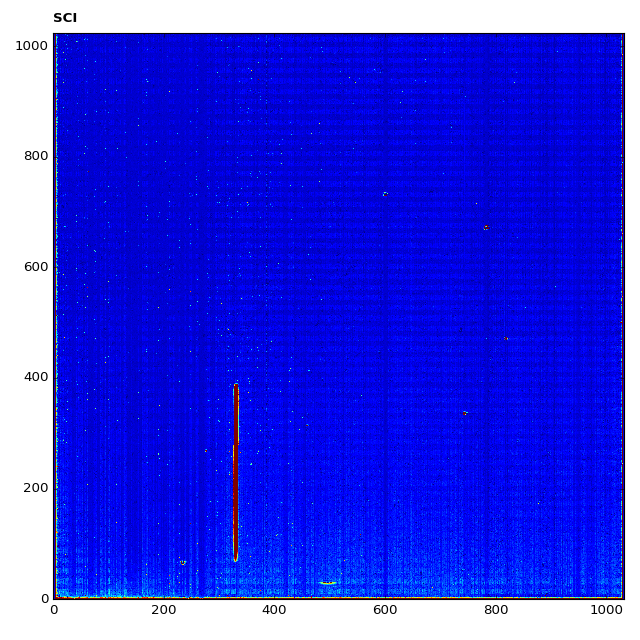

In [48]:
# plot--------------------------------------
%matplotlib notebook
from matplotlib.colors import LogNorm

# open the input image as a jwst data model
with datamodels.open(assign_wcs_output_file) as dm:
    
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))

    # show last frame of first integration
    axs.imshow(dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
    axs.annotate('SCI', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

    plt.tight_layout()
    plt.show()

### ASSIGN_WCS: perform some transforms

1. Display the available coordinate frames

2. perform some transfer from pixel to WCS

In [49]:
# using image in previous cell, select pixel to check, 
# comment out if you want to use pixel defined earlier
#pixel = [560,237]

# open the input file as a jwst data model
with datamodels.open(assign_wcs_output_file) as dm:

    # print available coordinate frames
    print "Available coordinate frames:" 
    print(", ".join(dm.meta.wcs.available_frames))
    print ""

    # perform transforms on pixel
    ra, dec, wav = dm.meta.wcs(pixel[0],pixel[1])

    print "Pixel: %d, %d" % (pixel[0],pixel[1])
    print "assign_wcs RA, DEC (deg): %0.7f %0.7f" % (ra,dec)
    print "assing_wcs Wavelength (micron): %0.3f" % wav
    

Available coordinate frames:
detector, world

Pixel: 331, 297
assign_wcs RA, DEC (deg): 0.0276245 0.0207805
assing_wcs Wavelength (micron): 8.392


## FLAT_FIELD step =============================================
The flat_field step divides the image by a flat-field reference image and updates the DQ array to indicate where no flat-field is available for a pixel. See:

http://ssb.stsci.edu/doc/jwst_git/docs/flatfield/html/

We will define where we want the output written (removing any file from a previous run)

### FLAT_FIELD: load module and show options

In [50]:
# import the step
from jwst.flatfield import flat_field_step

# print the description and options
print flat_field_step.FlatFieldStep.__doc__
print flat_field_step.FlatFieldStep.spec

# set the output file name
flat_field_output_file = os.path.join(output_dir,'%s_flat_field.fits' % input_basename)

# delete output from a previous run
try:
    os.remove(flat_field_output_file)
except OSError:
    pass


    FlatFieldStep: Flat-field a science image using a flatfield reference image.
    

        # Suffix for optional output file for interpolated flat fields.
        flat_suffix = string(default=None)
    


### FLAT_FIELD: run step

In [51]:
# run the flat_field step
flat_field_step.FlatFieldStep.call(assign_wcs_output_file, output_file=flat_field_output_file)

2017-02-16 11:26:09,210 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2017-02-16 11:26:09,655 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args ('det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_assign_wcs.fits',).
2017-02-16 11:26:10,601 - stpipe.FlatFieldStep - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored
2017-02-16 11:26:10,602 - stpipe.FlatFieldStep - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored
2017-02-16 11:26:10,603 - stpipe.FlatFieldStep - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored
2017-02-16 11:26:10,609 - stpipe.FlatFieldStep - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored
2017-02-16 11:26:10,894 - stpipe.FlatFieldStep - INFO - Saving file /Users/patrickkavanagh/mirisim/testing/lrssim/slit/det_

### FLAT_FIELD: output check

1. check the output fits file contains the calibration step information, look at the new extension table

In [52]:
# check the output fits file information using astropy fits
with fits.open(flat_field_output_file) as hdulist:
    
    # check the calibration step information
    print'Check flat_field step information status:'
    step_check = hdulist[0].header['S_FLAT']
    print step_check + '\n'
    
    # print the fits extension table and properties
    hdulist.info()

Check flat_field step information status:
COMPLETE

Filename: det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_flat_field.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     237   ()      
  1  SCI         ImageHDU         9   (1032, 1024)   float32   
  2  DQ          ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  3  ERR         ImageHDU         8   (1032, 1024)   float32   
  4  ASDF        ImageHDU         7   (6472800,)   uint8   


### FLAT_FIELD: input/output image checks

1. Display the input and output images

<IPython.core.display.Javascript object>


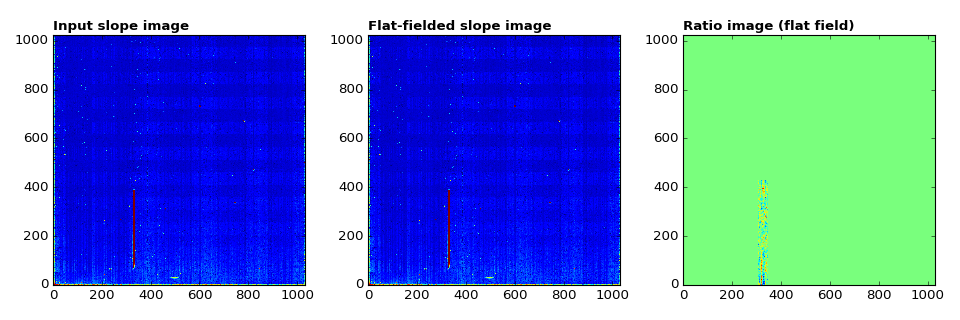

2017-02-16 11:26:14,557 - stpipe - WARNING - /Users/patrickkavanagh/anaconda/envs/jwstb7/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in divide



In [53]:
# open the input and output image as jwst data models
with datamodels.open(assign_wcs_output_file) as in_dm:
    with datamodels.open(flat_field_output_file) as out_dm:

        # plot--------------------------------------
        # show the input, output and ratio image, 
        # which will correspond to the flat field.
        %matplotlib notebook
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))

        # show the input
        axs[0].imshow(in_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
        axs[0].annotate('Input slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_axis_bgcolor('black')
        
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=10)
        axs[1].annotate('Flat-fielded slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_axis_bgcolor('black')
        
        axs[2].imshow(in_dm.data / out_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=0.98, vmax=1.02)
        axs[2].annotate('Ratio image (flat field)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[2].set_axis_bgcolor('black')

        plt.tight_layout()
        plt.show()

## SRCTYPE step =======================================
This step checks or sets whether a spectroscopic source should be treated as a point or extended object, writing the appropriate value to a keyword. Allowable values are POINT, EXTENDED and UNKNOWN. This will usually be set from the APT by an observer. If the user sets UNKNOWN, a default of POINT is set for the LRS. See:

http://ssb.stsci.edu/doc/jwst_git/docs/srctype/html/

We will define where we want the output written (removing any file from a previous run).

### SRCTYPE: load module and show options

In [54]:
# import the step
from jwst.srctype import srctype_step

# print the description and options
print srctype_step.SourceTypeStep.__doc__
print srctype_step.SourceTypeStep.spec

# set the output file name
srctype_output_file = os.path.join(output_dir,'%s_srctype.fits' % input_basename)

# delete output from a previous run
try:
    os.remove(srctype_output_file)
except OSError:
    pass


    SourceTypeStep: Selects and sets a source type based on various inputs.
    The source type is used in later calibrations to determine the appropriate
    methods to use. Input comes from either the SRCTYPE keyword value, which
    is populated from user info in the APT, or the NIRSpec MSA planning tool.
    

    


### SRCTYPE: run custom step
The srctype task can not be run as a standalone step at the moment. What follows is some simple code that does the same job, ie, writes the srctype keyword with the default LRS value 'POINT'

In [55]:
# run the srctype step (THIS WILL NOT WORK!)
# srctype_step.SourceTypeStep.call(flat_field_output_file, output_file=srctype_output_file)

In [56]:
# TEMPORARY SRCTYPE STEP
# open the flat_field output as a jwst data model
with datamodels.open(flat_field_output_file) as dm:
    
    # manually set the source_type keyword to 'POINT'
    dm.meta.target.source_type = 'POINT'
    
    # save the file
    dm.save(srctype_output_file)

### SRCTYPE: output check

1. check the output fits file contains the calibration step information, look at the new extension table

In [57]:
# check the output fits file information using astropy fits
with fits.open(flat_field_output_file) as hdulist:
    
    # print the fits extension table and properties
    hdulist.info()

Filename: det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_flat_field.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     237   ()      
  1  SCI         ImageHDU         9   (1032, 1024)   float32   
  2  DQ          ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  3  ERR         ImageHDU         8   (1032, 1024)   float32   
  4  ASDF        ImageHDU         7   (6472800,)   uint8   


### SRCTYPE: check the SRCTYPE keyword value

In [58]:
# open the srctype output as a jwst data model
with datamodels.open(srctype_output_file) as dm:
    
    # print the value of the srctype keyword
    print "SRCTYPE: %s" % dm.meta.target.source_type
    

SRCTYPE: POINT


## PHOTOM step =======================================
This step extracts photom conversion factors to convert count rates to absolute flux units and writes them to the input header. It also writes the pixel area keywords. These are read from a photometric reference file. See:

http://ssb.stsci.edu/doc/jwst_git/docs/photom/html/

We will define where we want the output written (removing any file from a previous run). This is the last step in the level 2b pipeline so we adjust the output file names to reflect this ('_cal.fits').

### PHOTOM: load module and show options

In [59]:
# import the step
from jwst.photom import photom_step

# print the description and options
print photom_step.PhotomStep.__doc__
print photom_step.PhotomStep.spec

# set the output file name
photom_output_file = os.path.join(output_dir,'%s_cal.fits' % input_basename)

# delete output from a previous run
try:
    os.remove(photom_output_file)
except OSError:
    pass


    PhotomStep: Module for extraction photom conversion factor(s)
        and writing them to input header
    

    pre_hooks = string_list(default=list())
    post_hooks = string_list(default=list())

    output_dir = string(default=None) # Directory path for output files
    output_file = output_file(default=None) # File to save output to.
    skip = boolean(default=False) # Skip this step
    


### PHOTOM: run step

In [61]:
photom_step.PhotomStep.call(srctype_output_file, output_file=photom_output_file)

2017-02-16 11:28:29,488 - stpipe.PhotomStep - INFO - PhotomStep instance created.
2017-02-16 11:28:30,467 - stpipe.PhotomStep - INFO - Prefetch for AREA reference file is 'N/A'.
2017-02-16 11:28:30,468 - stpipe.PhotomStep - INFO - Prefetch for PHOTOM reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0014.fits'.
2017-02-16 11:28:30,596 - stpipe.PhotomStep - INFO - Step PhotomStep running with args ('det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_srctype.fits',).
2017-02-16 11:28:31,411 - stpipe.PhotomStep - INFO - Using photom reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_photom_0014.fits
2017-02-16 11:28:31,931 - stpipe.PhotomStep - INFO - Using area reference file: N/A
2017-02-16 11:28:32,069 - stpipe.PhotomStep - INFO - Relative response table written.
2017-02-16 11:28:32,070 - stpipe.PhotomStep - INFO - Writing PHOTMJSR with value: 1
2017-02-16 11:28:32,147 - stpipe.PhotomStep - 

### PHOTOM: output check

In [62]:
# check the output fits file information using astropy fits
with fits.open(photom_output_file) as hdulist:
    
    # check the calibration step information
    print'Check photom step information status:'
    step_check = hdulist[0].header['S_PHOTOM']
    print step_check + '\n'
    
    # print the fits extension table and properties
    hdulist.info()

Check photom step information status:
COMPLETE

Filename: det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_cal.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     255   ()      
  1  SCI         ImageHDU         9   (1032, 1024)   float32   
  2  DQ          ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  3  ERR         ImageHDU         8   (1032, 1024)   float32   
  4  RELSENS     BinTableHDU     13   237R x 2C   [D, D]   
  5  ASDF        ImageHDU         7   (6477050,)   uint8   


### PHOTOM: check the correct photometric keywords in output header

1. Get the photometric information from the output header

In [63]:
with datamodels.open(photom_output_file) as dm:

    print "Photometric conversions (Flux density producing 1 cps)"
    print "%0.2e microJy/arcsec^2" % dm.meta.photometry.conversion_microjanskys
    print "%0.2e MJy/sr" % dm.meta.photometry.conversion_megajanskys


Photometric conversions (Flux density producing 1 cps)
2.35e+01 microJy/arcsec^2
1.00e+00 MJy/sr


### CALIBRATION CHECKS BEFORE SPECTRL EXTRACTION =======================================

The level 2B file is the calibrated slope product. We can:

1. check that all calibration steps have been applied

2. check the contents of the output directory

3. show the evolution of the data through 1B - 2A - 2B stages

In [64]:
# check the output fits file information using astropy fits
with fits.open(photom_output_file) as hdulist:
    
    # print extension table info
    hdulist.info()

    # check the status of each 2A calibration step
    print ""
    print 'Status of 2A calibration steps in output header:'
    stepsCheck = ['S_DQINIT', 'S_SATURA', 'S_REFPIX', 'S_RSCD', 'S_LASTFR', 'S_LINEAR', 'S_DARK',
                  'S_JUMP', 'S_RAMP', 'S_WCS', 'S_FLAT', 'S_PHOTOM']
    for key in stepsCheck:
        print key + ': ' + hdulist[0].header[key]
    
# check contents of output directory
print '\nResults path contains:'
for outfile in os.listdir(output_dir):
    print "%s" % outfile

Filename: det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_cal.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     255   ()      
  1  SCI         ImageHDU         9   (1032, 1024)   float32   
  2  DQ          ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  3  ERR         ImageHDU         8   (1032, 1024)   float32   
  4  RELSENS     BinTableHDU     13   237R x 2C   [D, D]   
  5  ASDF        ImageHDU         7   (6477050,)   uint8   

Status of 2A calibration steps in output header:
S_DQINIT: COMPLETE
S_SATURA: COMPLETE
S_REFPIX: COMPLETE
S_RSCD: COMPLETE
S_LASTFR: COMPLETE
S_LINEAR: COMPLETE
S_DARK: COMPLETE
S_JUMP: COMPLETE
S_RAMP: COMPLETE
S_WCS: COMPLETE
S_FLAT: COMPLETE
S_PHOTOM: COMPLETE

Results path contains:
det_image_1_MIRIMAGE_P750Lexp1_assign_wcs.fits
det_image_1_MIRIMAGE_P750Lexp1_cal.fits
det_image_1_MIRIMAGE_P750Lexp1_dark_current.fits
det_image_1_MIRIMAGE_P750Lexp1_dq_init.fits
de

<IPython.core.display.Javascript object>


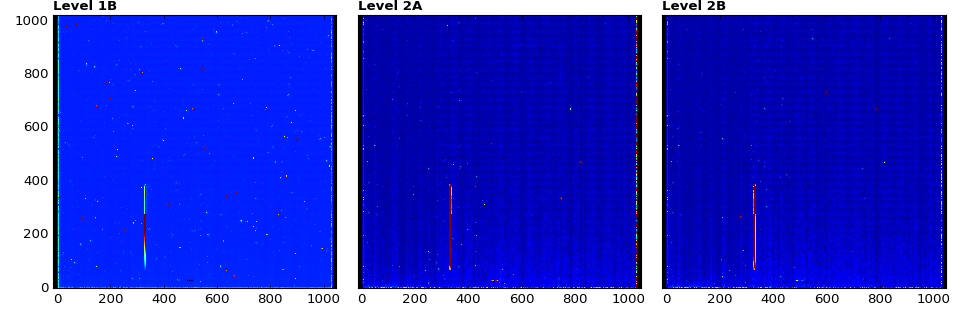

In [65]:
# open the input and output image as jwst data models
with datamodels.open(input_file) as lvl1b_dm:
    with datamodels.open(ramp_fitting_output_file) as lvl2a_dm:
            with datamodels.open(photom_output_file) as lvl2b_dm:

                # plot--------------------------------------
                # show the input ramp image and the calibrated
                # slope image.
                %matplotlib notebook
                fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

                # 1B image
                axs[0].imshow(lvl1b_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
                axs[0].annotate('Level 1B', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
                axs[0].set_axis_bgcolor('black')
                
                # 2A image
                axs[1].imshow(lvl2a_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=20)
                axs[1].annotate('Level 2A', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
                axs[1].set_axis_bgcolor('black')
                
                # 2B image
                axs[2].imshow(lvl2b_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=-1, vmax=20)
                axs[2].annotate('Level 2B', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
                axs[2].set_axis_bgcolor('black')

                plt.tight_layout()
                plt.show()

## EXTRACT_1D step ======================================
This step extracts a 1D spectrum from the calibrated 2D image. See:

http://ssb.stsci.edu/doc/jwst_git/docs/extract_1d/html/

We will define where we want the output written (removing any file from a previous run)

#### Note that the flux units produced extract_1d are not correct. How flux calibration is applied in the pipeline is still a work in progress.

### EXTRACT_1D: load module and show options

In [66]:
# import the step
from jwst.extract_1d import extract_1d_step

# print the description and options
print extract_1d_step.Extract1dStep.__doc__
print extract_1d_step.Extract1dStep.spec

# set the output file name
extract_1d_output_file = os.path.join(output_dir,'%s_x1d.fits' % input_basename)

# delete output from a previous run
try:
    os.remove(extract_1d_output_file)
except OSError:
    pass


    Extract1dStep: Extract a 1-d spectrum from 2-d data
    

    # Boxcar smoothing width for background regions.
    smoothing_length = integer(default=None)
    # Order of polynomial fit to one column (or row if the dispersion
    # direction is vertical) of background regions.
    bkg_order = integer(default=None, min=0)
    


### EXTRACT_1D: run step

In [68]:
extract_1d_step.Extract1dStep.call(photom_output_file, output_file=extract_1d_output_file)

2017-02-16 11:30:44,036 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.
2017-02-16 11:30:45,111 - stpipe.Extract1dStep - INFO - Prefetch for EXTRACT1D reference file is '/Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0004.json'.
2017-02-16 11:30:45,263 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_cal.fits',).
2017-02-16 11:30:46,110 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_extract1d_0004.json
2017-02-16 11:30:46,176 - stpipe.Extract1dStep - INFO - Aperture limit(s) truncated due to WCS domain
2017-02-16 11:30:46,206 - stpipe.Extract1dStep - WARNING - Using RELSENS, 386 elements were extrapolated; these values will be set to 1.
2017-02-16 11:30:46,349 - stpipe.Extract1dStep - INFO - Saving file /Users/patrickkavanagh/mirisim/testing/lrssim/slit/det_image_1_M

### EXTRACT_1D: output check

In [69]:
# check the output fits file information using astropy fits
with fits.open(extract_1d_output_file) as hdulist:
    
    # print the fits extension table and properties
    hdulist.info()

Filename: det_image_1_MIRIMAGE_P750Lexp1_step-output/det_image_1_MIRIMAGE_P750Lexp1_x1d.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     253   ()      
  1  EXTRACT1D   BinTableHDU     26   386R x 8C   [D, D, D, J, D, D, D, D]   
  2  ASDF        ImageHDU         7   (28884,)   uint8   


### EXTRACT_1D: plot spectrum

<IPython.core.display.Javascript object>


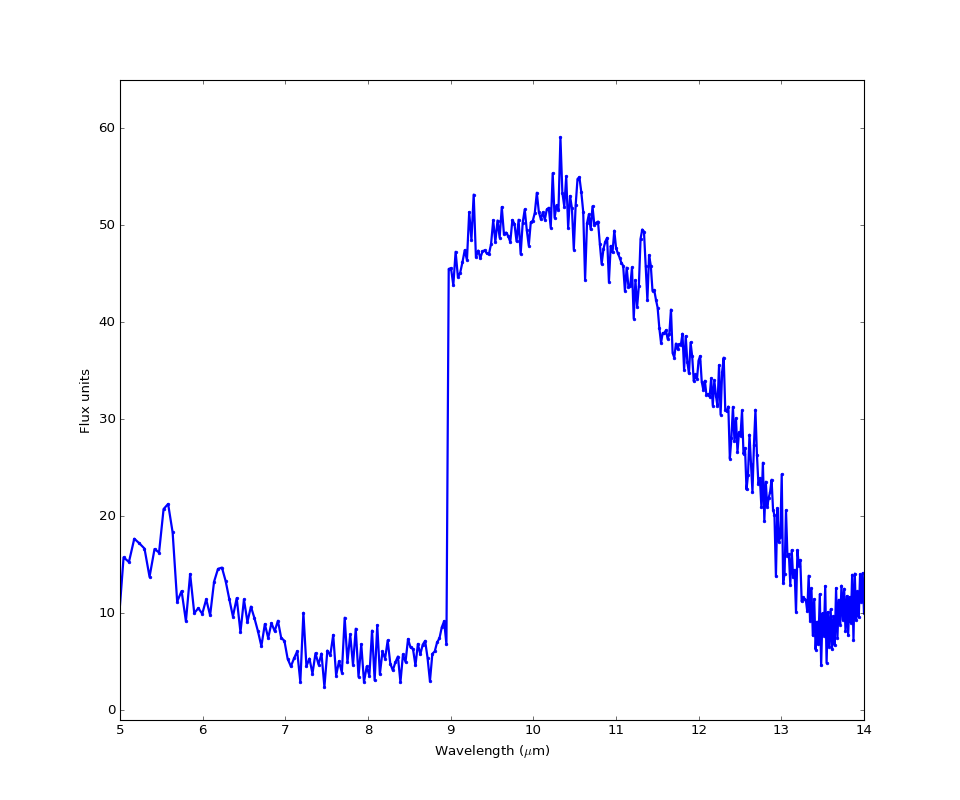

In [71]:
from jwst.datamodels import SpecModel

# open the spectrum as a jwst data model
with SpecModel(extract_1d_output_file) as spec_dm:

    # plot--------------------------------------
    # simple XY plot of the spectrum
    %matplotlib notebook
    fig, axs = plt.subplots(1, 1, figsize=(12, 10))

    axs.plot(spec_dm.spec_table['WAVELENGTH'], spec_dm.spec_table['FLUX'], c='b', marker='.', markersize=5, linestyle='-', linewidth=2)
    axs.set_ylabel(r'Flux units')
    axs.set_xlabel(r'Wavelength ($\mu$m)')
    axs.set_ylim(-1,65)
    axs.set_xlim(5,14)

    plt.show()